# Reference: Surface Observations with StationPlot

Minimal example of requesting METAR surface observations from EDEX and plotting with MetPy StationPlot.

In [1]:
from awips.dataaccess import DataAccessLayer
from dynamicserialize.dstypes.com.raytheon.uf.common.time import TimeRange
from datetime import datetime, timedelta, UTC
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from metpy.calc import wind_components
from metpy.plots import StationPlot, sky_cover
from metpy.units import units

In [2]:
# Connect to EDEX and create request
DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
request = DataAccessLayer.newDataRequest("obs")

# Set parameters
request.setParameters("stationName", "longitude", "latitude",
                      "temperature", "dewpoint", "windDir", "windSpeed", "skyCover")

# Select stations (subset for cleaner plot)
stations = ['KORD', 'KDFW', 'KDEN', 'KLAX', 'KJFK', 'KATL', 'KSFO', 'KBOS',
            'KMIA', 'KPHX', 'KSEA', 'KMSP', 'KSLC', 'KSTL', 'KMCI', 'KPIT']
request.setLocationNames(*stations)

In [3]:
# Define time range (last hour)
now = datetime.now(UTC)
start = now - timedelta(hours=1)
time_range = TimeRange(start, now)

# Get data
response = DataAccessLayer.getGeometryData(request, time_range)
print(f"Retrieved {len(response)} records")

Retrieved 140 records


In [4]:
# Helper function for cloud cover codes
def get_cloud_cover(code):
    if 'OVC' in code: return 8
    elif 'BKN' in code: return 6
    elif 'SCT' in code: return 4
    elif 'FEW' in code: return 2
    else: return 0

# Parse response into arrays
data = {'stid': [], 'lat': [], 'lon': [], 'temp': [], 'dwpt': [], 
        'wdir': [], 'wspd': [], 'sky': []}
seen = set()

for ob in reversed(response):
    params = ob.getParameters()
    if 'stationName' in params:
        stn = ob.getString('stationName')
        if stn not in seen:
            seen.add(stn)
            data['stid'].append(stn)
            data['lat'].append(ob.getNumber('latitude'))
            data['lon'].append(ob.getNumber('longitude'))
            data['temp'].append(ob.getNumber('temperature'))
            data['dwpt'].append(ob.getNumber('dewpoint'))
            data['wdir'].append(ob.getNumber('windDir'))
            data['wspd'].append(ob.getNumber('windSpeed'))
    elif 'skyCover' in params and len(data['sky']) < len(data['stid']):
        data['sky'].append(get_cloud_cover(ob.getString('skyCover')))

# Pad sky cover if needed
while len(data['sky']) < len(data['stid']):
    data['sky'].append(0)

In [5]:
# Convert to arrays with units
lat = np.array(data['lat'])
lon = np.array(data['lon'])
temp = np.array(data['temp'], dtype=float) * units.degC
dwpt = np.array(data['dwpt'], dtype=float) * units.degC
wdir = np.array(data['wdir'], dtype=float)
wdir[wdir == -9999] = np.nan
wspd = np.array(data['wspd'], dtype=float) * units.knots
sky = np.array(data['sky'])

# Calculate wind components
u, v = wind_components(wspd, wdir * units.degree)

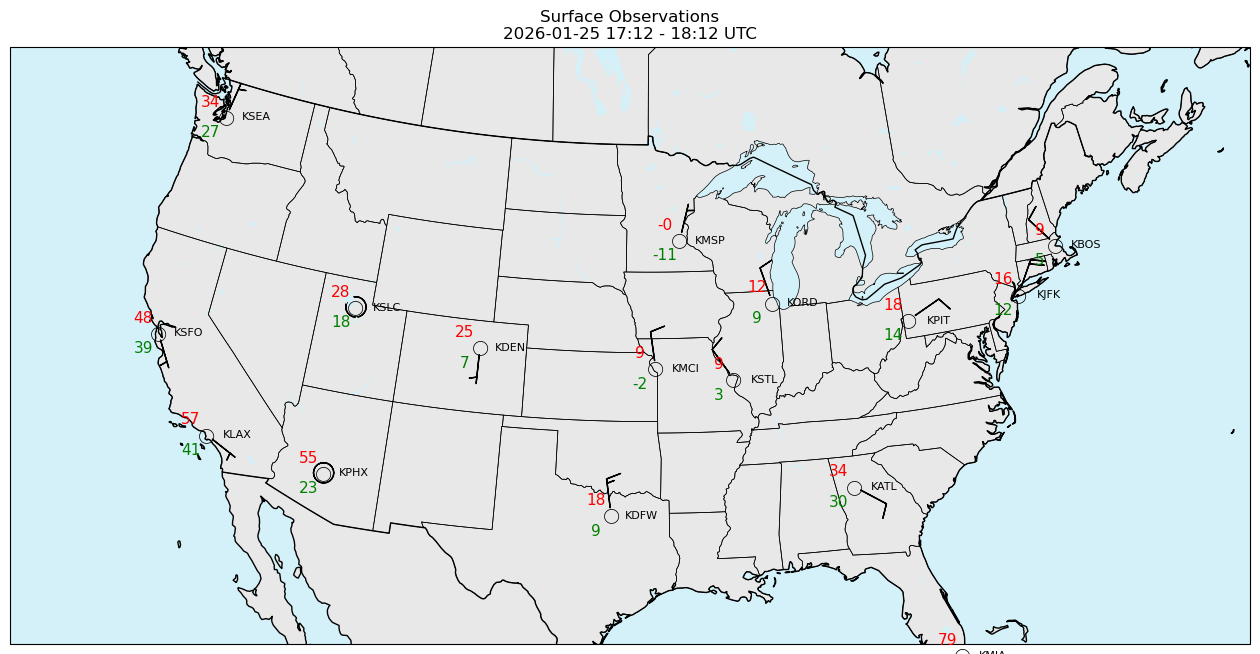

In [6]:
# Plot
proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=35)
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj)

ax.add_feature(cfeature.LAND, facecolor='#e8e8e8')
ax.add_feature(cfeature.OCEAN, facecolor='#d4f1f9')
ax.add_feature(cfeature.LAKES, facecolor='#d4f1f9')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.set_extent([-125, -67, 24, 50])

# Create station plot
sp = StationPlot(ax, lon, lat, transform=ccrs.PlateCarree(), fontsize=11)

# Plot elements
sp.plot_parameter('NW', temp.to('degF').m, color='red', formatter=lambda x: f'{x:.0f}')
sp.plot_parameter('SW', dwpt.to('degF').m, color='green', formatter=lambda x: f'{x:.0f}')
sp.plot_barb(u, v)
sp.plot_symbol('C', sky, sky_cover)
sp.plot_text((2, 0), data['stid'], fontsize=8)

ax.set_title(f'Surface Observations\n{start.strftime("%Y-%m-%d %H:%M")} - {now.strftime("%H:%M")} UTC')
plt.show()